In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import relu

In [2]:
class ComplexCNN2D(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ComplexCNN2D, self).__init__()
        
        # 输入形状: [batch, 2, num_features, 1] (2通道: 实部+虚部)
        self.conv1 = nn.Conv2d(2, 64, kernel_size=(3, 1), padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 1), padding=(1, 0))
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 1), padding=(1, 0))
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.2)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 1), padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout4 = nn.Dropout(0.2)
        
        # 残差连接
        self.shortcut1 = nn.Conv2d(64, 128, kernel_size=(1, 1))
        self.shortcut2 = nn.Conv2d(128, 256, kernel_size=(1, 1))
        self.shortcut3 = nn.Conv2d(256, 512, kernel_size=(1, 1))
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # 第一层
        identity = x
        x = relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        
        # 第二层
        identity = self.shortcut1(x)
        x = relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = x + identity
        
        # 第三层
        identity = self.shortcut2(x)
        x = relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)
        x = x + identity
        
        # 第四层
        identity = self.shortcut3(x)
        x = relu(self.bn4(self.conv4(x)))
        x = self.dropout4(x)
        x = x + identity
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
class SignalDataset(Dataset):
    def __init__(self, features, labels, scaler_real=None, scaler_imag=None):
        # 分离实部和虚部并标准化
        real = np.real(features)
        imag = np.imag(features)
        
        if scaler_real:
            real = scaler_real.transform(real)
            imag = scaler_imag.transform(imag)
        
        # 合并为2通道输入 [batch, 2, features, 1]
        self.x = torch.FloatTensor(np.stack([real, imag], axis=1)[..., np.newaxis])
        self.y = torch.LongTensor(labels.values if isinstance(labels, pd.Series) else labels)
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [4]:
sizes = [128, 256, 512, 1024, 2048, 4096]
accuracies = {'ComplexCNN2D': []}

# 加载数据
X_trains, y_trains = {}, {}
X_tests, y_tests = {}, {}

for size in sizes:
    # 训练集
    df_train = shuffle(pd.read_csv(f'../preprocessed/combined_features_{size}.csv'), random_state=42)
    y_trains[size] = df_train['label']
    X_trains[size] = df_train.drop('label', axis=1).applymap(lambda x: complex(x)).values
    
    # 测试集
    df_test = shuffle(pd.read_csv(f'../preprocessed/combined_features_{size}_test.csv'), random_state=42)
    y_tests[size] = df_test['label']
    X_tests[size] = df_test.drop('label', axis=1).applymap(lambda x: complex(x)).values

C:\Users\admin\AppData\Local\Temp\ipykernel_23664\727200205.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_trains[size] = df_train.drop('label', axis=1).applymap(lambda x: complex(x)).values
C:\Users\admin\AppData\Local\Temp\ipykernel_23664\727200205.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_tests[size] = df_test.drop('label', axis=1).applymap(lambda x: complex(x)).values
C:\Users\admin\AppData\Local\Temp\ipykernel_23664\727200205.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_trains[size] = df_train.drop('label', axis=1).applymap(lambda x: complex(x)).values
C:\Users\admin\AppData\Local\Temp\ipykernel_23664\727200205.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_tests[size] = df_test.drop('label', axis=1).applymap(lambda x: complex(x)).values
C:\Users\admin\AppData\Local\Temp\ipykernel_23664\727200

In [5]:
# 添加必要的导入
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title='混淆矩阵'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title}', fontproperties="SimHei")
    plt.ylabel('真实类别', fontproperties="SimSun")
    plt.xlabel('预测类别', fontproperties="SimSun")
    plt.xticks(range(4), ['bladerf', 'hackrf0', 'hackrf1', 'limesdr'])
    plt.yticks(range(4), ['bladerf', 'hackrf0', 'hackrf1', 'limesdr'])
    plt.savefig(f'./img/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_acc = 0
for size in sizes:
    # 数据标准化
    scaler_real = StandardScaler().fit(np.real(X_trains[size]))
    scaler_imag = StandardScaler().fit(np.imag(X_trains[size]))
    
    # 创建数据集
    train_dataset = SignalDataset(X_trains[size], y_trains[size], scaler_real, scaler_imag)
    test_dataset = SignalDataset(X_tests[size], y_tests[size], scaler_real, scaler_imag)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # 初始化模型
    num_features = X_trains[size].shape[1]
    num_classes = len(np.unique(y_trains[size]))
    model = ComplexCNN2D(num_features, num_classes).to(device)
    
    # 训练配置
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
    
    print(f"\n=== Training for size {size} ===")
    best_acc = 0.0

    epoch = 30
    
    for epoch_item in range(epoch):  # 适当增加epoch
        model.train()
        total_loss = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # 验证
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        
        acc = correct / total
        scheduler.step(acc)
        
        if acc > best_acc:
            best_acc = acc

        if best_acc > max_acc:
            torch.save(model.state_dict(), f'./model_save/ComplexCNN.pth')
        
        print(f'Epoch {epoch_item+1}/{epoch}: Loss={total_loss/len(train_loader):.4f}, Acc={acc:.4f}, Best Acc={best_acc:.4f}')
    
    accuracies['ComplexCNN2D'].append(best_acc)
    print(f"⭐ Best Accuracy for size {size}: {best_acc:.4f}")


=== Training for size 128 ===
Epoch 1/30: Loss=0.7984, Acc=0.5930, Best Acc=0.5930
Epoch 2/30: Loss=0.6845, Acc=0.6640, Best Acc=0.6640
Epoch 3/30: Loss=0.6594, Acc=0.6540, Best Acc=0.6640
Epoch 4/30: Loss=0.6422, Acc=0.6597, Best Acc=0.6640
Epoch 5/30: Loss=0.6272, Acc=0.6558, Best Acc=0.6640
Epoch 6/30: Loss=0.6156, Acc=0.6737, Best Acc=0.6737
Epoch 7/30: Loss=0.6173, Acc=0.7017, Best Acc=0.7017
Epoch 8/30: Loss=0.5977, Acc=0.6957, Best Acc=0.7017
Epoch 9/30: Loss=0.5938, Acc=0.7040, Best Acc=0.7040
Epoch 10/30: Loss=0.5845, Acc=0.7027, Best Acc=0.7040
Epoch 11/30: Loss=0.5789, Acc=0.6915, Best Acc=0.7040
Epoch 12/30: Loss=0.5728, Acc=0.7025, Best Acc=0.7040
Epoch 13/30: Loss=0.5693, Acc=0.7073, Best Acc=0.7073
Epoch 14/30: Loss=0.5635, Acc=0.6983, Best Acc=0.7073
Epoch 15/30: Loss=0.5694, Acc=0.7200, Best Acc=0.7200
Epoch 16/30: Loss=0.5579, Acc=0.7093, Best Acc=0.7200
Epoch 17/30: Loss=0.5594, Acc=0.7305, Best Acc=0.7305
Epoch 18/30: Loss=0.5525, Acc=0.7017, Best Acc=0.7305
Epoch 

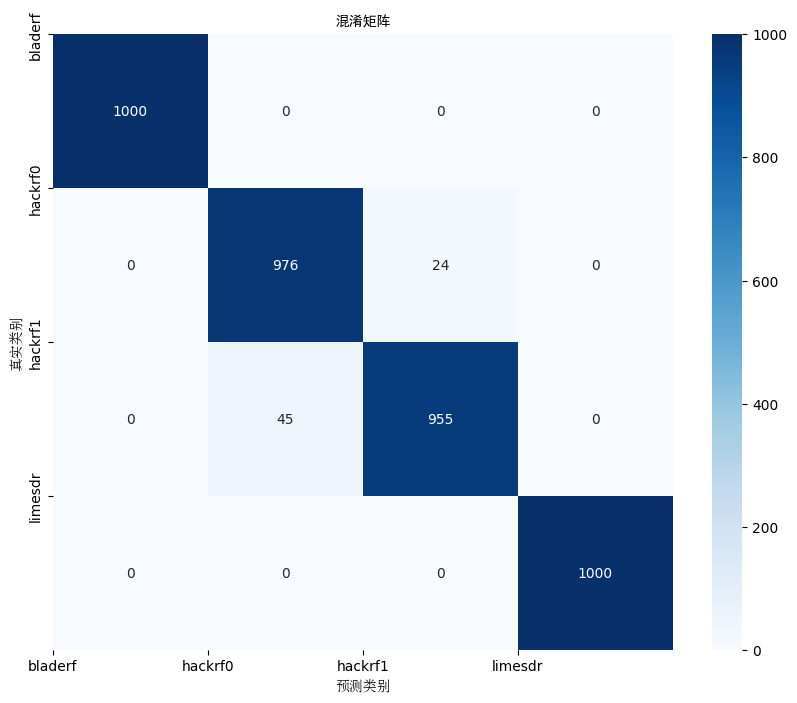

In [7]:
# 绘制混淆矩阵
plot_confusion_matrix(all_labels, all_preds)

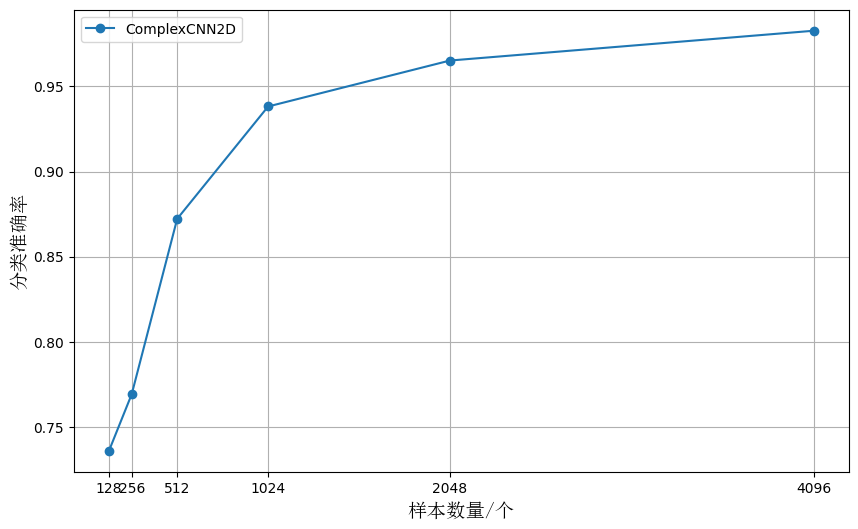

In [18]:
plt.figure(figsize=(10, 6))
plt.gca().set_facecolor('white')
plt.plot(sizes, accuracies['ComplexCNN2D'], 'o-', label='ComplexCNN2D')
plt.xlabel('样本数量/个', fontsize=14, fontproperties="SimSun")
plt.ylabel('分类准确率', fontsize=14, fontproperties="SimSun")
plt.xticks(sizes)
plt.grid(True)
plt.legend()
plt.savefig('./img/complexCNN.png', dpi=600, bbox_inches='tight')
plt.show()